In [1]:
from __future__ import print_function

import math
from functools import partial

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.python.data import Dataset

tf.get_logger().setLevel('ERROR')
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [11]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
    return processed_features 

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()  
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [12]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2642.9,538.6,1427.4,500.7,3.9,2.0
std,2.1,2.0,12.6,2168.6,419.7,1153.3,384.1,1.9,1.1
min,32.5,-124.3,2.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1470.0,297.0,789.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2135.0,434.0,1171.0,409.5,3.5,1.9
75%,37.7,-118.0,37.0,3154.0,647.0,1721.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2645.6,541.4,1434.7,502.5,3.9,2.0
std,2.1,2.0,12.6,2207.2,425.9,1134.7,385.6,1.9,1.3
min,32.6,-124.3,1.0,15.0,3.0,9.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1437.8,295.8,791.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2112.0,432.0,1157.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3144.0,653.2,1720.2,606.0,4.7,2.3
max,41.8,-114.6,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.8
std,116.6
min,15.0
25%,119.2
50%,180.8
75%,265.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.2
std,114.5
min,15.0
25%,120.5
50%,179.2
75%,262.6
max,500.0


In [13]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]
correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


In [15]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [16]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}                                           

    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [30]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
  
    my_optimizer = partial(optimizers.SGD, learning_rate=learning_rate, clipnorm=5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
   

    training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)

    print("Training model...")
    print("RMSE (on training data):")
    
    training_rmse = []
    validation_rmse = []
    
    for period in range (0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))

        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")

    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor    

Training model...
RMSE (on training data):
  period 00 : 156.13
  period 01 : 116.20
  period 02 : 111.63
  period 03 : 110.47
  period 04 : 109.74
  period 05 : 109.19
  period 06 : 107.85
  period 07 : 107.26
  period 08 : 106.75
  period 09 : 106.17
Model training finished.


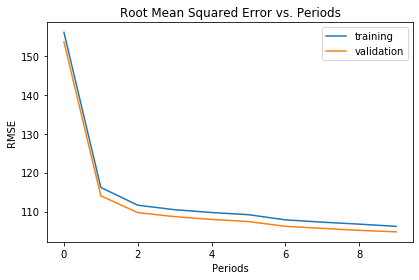

In [31]:
minimal_features = [
    "median_income",
    "latitude",
]

assert minimal_features, "You must select at least on feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

In [ ]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

In [37]:
LATITUDE_RANGES = zip(range(32, 44), range(33, 45))

def select_and_transform_features(source_df):
    selected_examples = pd.DataFrame()
    selected_examples["median_income"] = source_df["median_income"]
    
    for r in LATITUDE_RANGES:
        selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
            
    return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
#selected_training_targets = select_and_transform_features(training_targets)

selected_validation_examples = select_and_transform_features(validation_examples)
#selected_validation_targets = select_and_transform_features(validation_targets)

display.display(selected_training_examples.describe())
display.display(selected_validation_examples.describe())

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,3.9,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0
std,1.9,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1,0.0,0.0
min,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


,median_income
count,5000.0
mean,3.9
std,1.9
min,0.5
25%,2.6
50%,3.5
75%,4.7
max,15.0


In [38]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):


ValueError: in converted code:
    relative to C:\Users\reign\Anaconda3\envs\py375\lib\site-packages\tensorflow_core\python\feature_column:

    feature_column_v2.py:706 call
        return self.layer(features)
    feature_column_v2.py:540 call
        weight_var=weight_var)
    feature_column_v2.py:2411 _create_weighted_sum
        weight_var=weight_var)
    feature_column_v2.py:2417 _create_dense_column_weighted_sum
        tensor = column.get_dense_tensor(transformation_cache, state_manager)
    feature_column_v2.py:2845 get_dense_tensor
        return transformation_cache.get(self, state_manager)
    feature_column_v2.py:2608 get
        transformed = column.transform_feature(self, state_manager)
    feature_column_v2.py:2817 transform_feature
        input_tensor = transformation_cache.get(self.key, state_manager)
    feature_column_v2.py:2600 get
        raise ValueError('Feature {} is not in features dictionary.'.format(key))

    ValueError: Feature latitude_32_to_33 is not in features dictionary.
